In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from oggm import utils

In [18]:
dfi = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
dfi['REG'] = [s[6:8] for s in dfi.index]

dfir = dfi.groupby('REG').sum()
voli = dfir.vol_itmix_m3.sum()
voli_na = dfir.iloc[:-1].vol_itmix_m3.sum()
voli_bsl = dfir.vol_bsl_itmix_m3.sum()
df_vol = dfi.groupby('REG').sum()

In [19]:
exps = ['cru_160', 'cru_match_80', 'cru_match_160', 'cru_match_240', 'cera_match_160', 'cera_match_240', 'cera_nobias_240']
exps = ['cru_match_240', 'cru_match_240_ref00', 'era_match_240_ref00']  # , 'cera_match_240'

In [20]:
# We assume frac bsl is constant
frac_bsl = df_vol.vol_bsl_itmix_m3 / df_vol.vol_itmix_m3

In [21]:
o_asl = dict()
o_bsl = dict()
o_cor = dict()
o_cor_bsl = dict()
for exp in exps:
    print('')
    print(exp)
    odf_asl = pd.DataFrame()
    odf_bsl = pd.DataFrame()
    odf_cor = pd.DataFrame()
    odf_cor_bsl = pd.DataFrame()
    for reg in range(1, 20):
        fp = f'output_{exp}/RGI{reg:02d}.nc'
        if not os.path.exists(fp):
            print('RGI{:02d} no.'.format(reg))
            continue
        with xr.open_dataset(fp) as ds:
            odf_asl[f'RGI{reg:02d}'] = ds.volume.sum(dim='rgi_id').to_series()
            odf_bsl[f'RGI{reg:02d}'] = ds.volume_bsl.sum(dim='rgi_id').to_series()
            frac = df_vol.loc[f'{reg:02d}'].vol_itmix_m3 / odf_asl[f'RGI{reg:02d}'].iloc[-1] 
            odf_cor[f'RGI{reg:02d}'] = odf_asl[f'RGI{reg:02d}'] * frac
            print('RGI{:02d} Failing glaciers: {}. Cor frac: {:.2f}'.format(reg, int(ds.volume.isel(time=0).isnull().sum()), frac))
            odf_cor_bsl[f'RGI{reg:02d}'] = odf_cor[f'RGI{reg:02d}'] * frac_bsl[f'{reg:02d}']
            
    o_asl[exp] = odf_asl
    o_bsl[exp] = odf_bsl
    o_cor[exp] = odf_cor
    o_cor_bsl[exp] = odf_cor_bsl


cru_match_240
RGI01 Failing glaciers: 4. Cor frac: 1.81
RGI02 Failing glaciers: 1601. Cor frac: 1.09
RGI03 Failing glaciers: 121. Cor frac: 1.05
RGI04 Failing glaciers: 5. Cor frac: 4.36
RGI05 Failing glaciers: 2541. Cor frac: 1.17
RGI06 Failing glaciers: 5. Cor frac: 2.54
RGI07 Failing glaciers: 808. Cor frac: 4.19
RGI08 Failing glaciers: 5. Cor frac: 1.83
RGI09 Failing glaciers: 586. Cor frac: 0.84
RGI10 Failing glaciers: 124. Cor frac: 1.43
RGI11 Failing glaciers: 64. Cor frac: 0.66
RGI12 Failing glaciers: 356. Cor frac: 1.45
RGI13 Failing glaciers: 2014. Cor frac: 0.75
RGI14 Failing glaciers: 358. Cor frac: 0.89
RGI15 Failing glaciers: 145. Cor frac: 1.24
RGI16 Failing glaciers: 307. Cor frac: 1.22
RGI17 Failing glaciers: 22. Cor frac: 2.33
RGI18 Failing glaciers: 16. Cor frac: 1.11
RGI19 no.

cru_match_240_ref00
RGI01 Failing glaciers: 238. Cor frac: 1.64
RGI02 Failing glaciers: 2577. Cor frac: 0.81
RGI03 Failing glaciers: 314. Cor frac: 0.98
RGI04 Failing glaciers: 8. Cor frac: 

In [22]:
mdf_asl = pd.DataFrame()
mdf_bsl = pd.DataFrame()
mdf_cor = pd.DataFrame()
mdf_cor_bsl = pd.DataFrame()
for exp in exps:
    mdf_asl[exp] = o_asl[exp].sum(axis=1)
    mdf_bsl[exp] = o_bsl[exp].sum(axis=1)
    mdf_cor[exp] = o_cor[exp].sum(axis=1)
    mdf_cor_bsl[exp] = o_cor_bsl[exp].sum(axis=1)

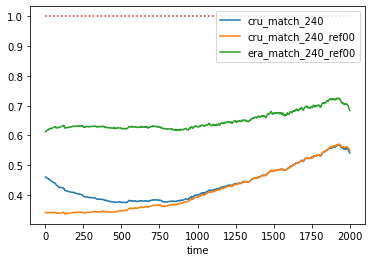

In [23]:
(mdf_asl / voli).plot();
plt.hlines([1], 0, 2000, color='C3', linestyle=':');

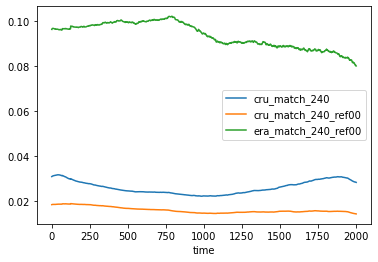

In [24]:
(mdf_bsl / mdf_asl).plot();

In [25]:
fac = voli / mdf_asl.iloc[-1]
fac

cru_match_240          1.847069
cru_match_240_ref00    1.815233
era_match_240_ref00    1.463391
Name: 2001.0, dtype: float32

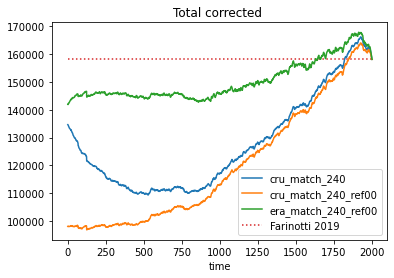

In [28]:
cor = (fac * mdf_asl) * 1e-9
cor.plot(legend=False);
plt.hlines([voli  * 1e-9], 0, 2000, color='C3', linestyle=':', label='Farinotti 2019');
plt.legend();

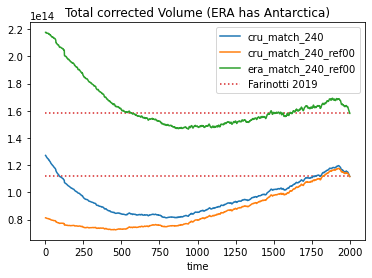

In [31]:
mdf_cor.plot(legend=False);
plt.hlines([voli, voli_na], 0, 2000, color='C3', linestyle=':', label='Farinotti 2019');
plt.title('Total corrected Volume (ERA has Antarctica)'); plt.legend();

In [32]:
mdf_cor

cru_match_240  cru_match_240_ref00  era_match_240_ref00
time                                                           
1.0      1.271706e+14         8.125147e+13         2.177235e+14
2.0      1.270575e+14         8.125220e+13         2.177957e+14
3.0      1.269242e+14         8.123835e+13         2.178099e+14
4.0      1.267166e+14         8.116718e+13         2.176745e+14
5.0      1.264066e+14         8.102307e+13         2.173547e+14
...               ...                  ...                  ...
1997.0   1.126357e+14         1.123118e+14         1.594693e+14
1998.0   1.123767e+14         1.121228e+14         1.592020e+14
1999.0   1.119474e+14         1.118046e+14         1.584839e+14
2000.0   1.118018e+14         1.117416e+14         1.582170e+14
2001.0   1.116905e+14         1.116905e+14         1.581566e+14

[2001 rows x 3 columns]

In [33]:
# SLR
rho = 900
rho_w = 1000
A_oc = 362.5 * 1e9
slr = (mdf_cor * (rho / rho_w) - mdf_cor_bsl) / A_oc
slr = slr.loc[1850] - slr

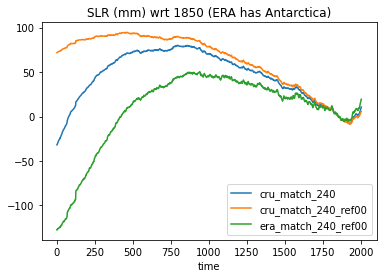

In [36]:
slr.plot();
plt.title('SLR (mm) wrt 1850 (ERA has Antarctica)');

In [35]:
slr[['cera_match_240', 'cera_nobias_240', 'cru_160']].loc[1850:].plot();

KeyError: "None of [Index(['cera_match_240', 'cera_nobias_240', 'cru_160'], dtype='object')] are in the [columns]"

RGI01 Failing glaciers: 16
RGI02 Failing glaciers: 295
RGI03 Failing glaciers: 35
RGI04 Failing glaciers: 4
RGI05 Failing glaciers: 927
RGI06 Failing glaciers: 8
RGI07 Failing glaciers: 92
RGI08 Failing glaciers: 24
RGI09 Failing glaciers: 5
RGI10 Failing glaciers: 231
RGI11 Failing glaciers: 9
RGI12 Failing glaciers: 356
RGI13 Failing glaciers: 1542
RGI14 Failing glaciers: 59
RGI15 Failing glaciers: 131
RGI16 Failing glaciers: 300
RGI17 Failing glaciers: 24
RGI18 Failing glaciers: 6


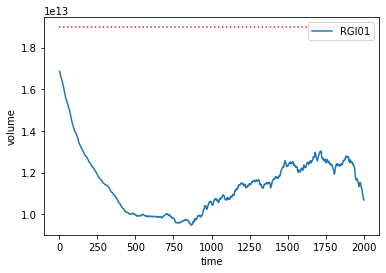

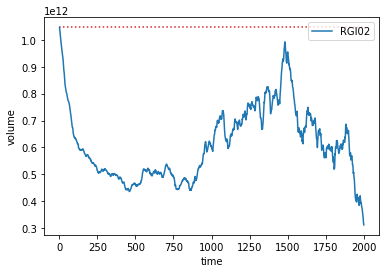

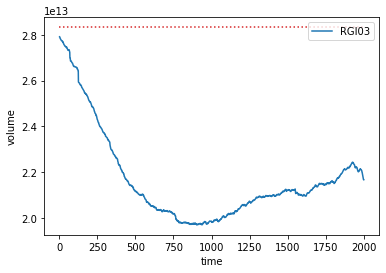

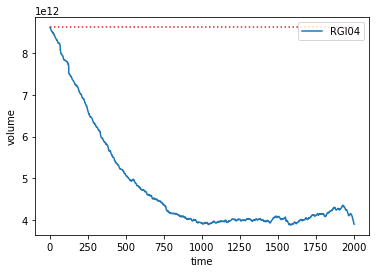

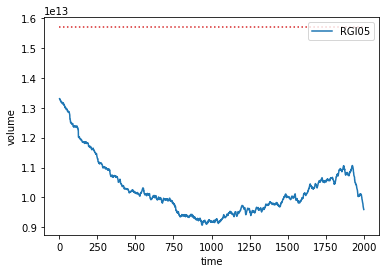

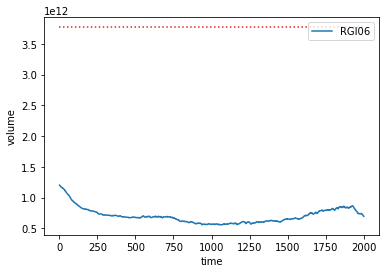

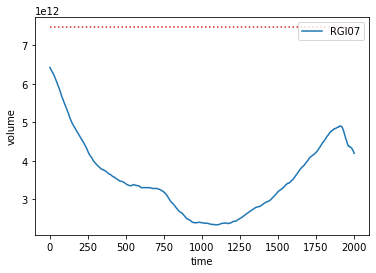

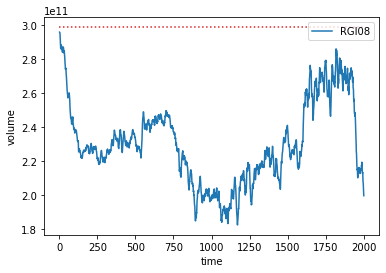

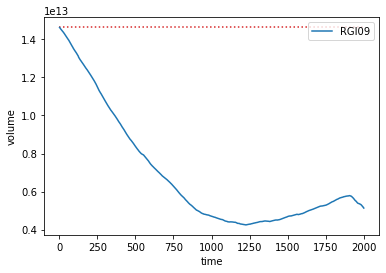

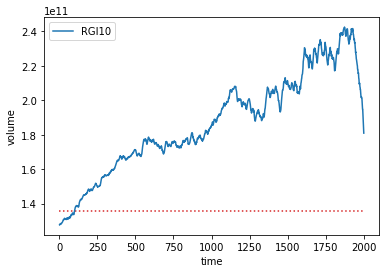

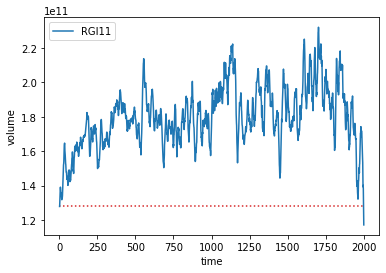

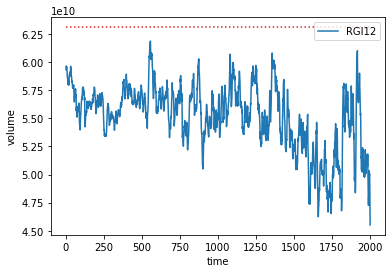

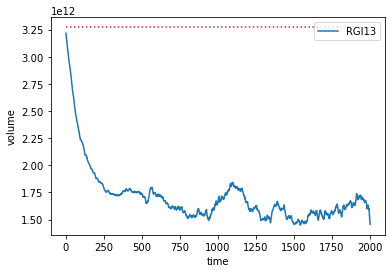

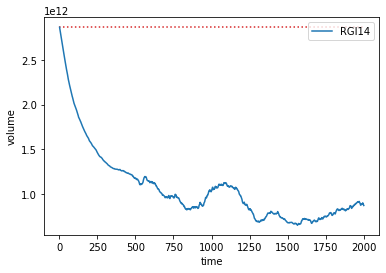

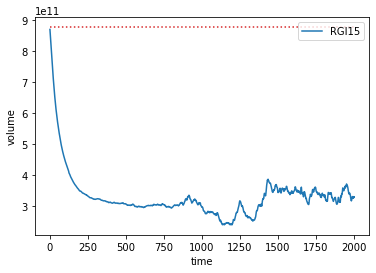

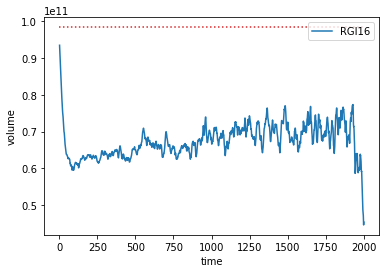

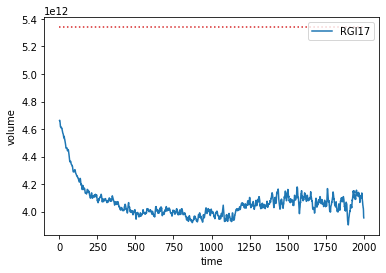

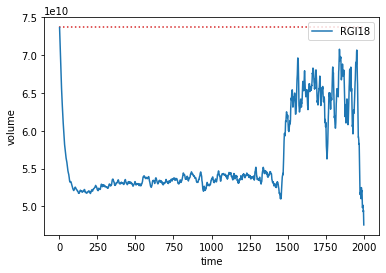

In [83]:
odf = pd.DataFrame()
for reg in range(1, 19):
    fp = f'output/RGI{reg:02d}.nc'
    if not os.path.exists(fp):
        continue
    with xr.open_dataset(fp) as ds:
        print('RGI{:02d} Failing glaciers: {}'.format(reg, int(ds.volume.isel(time=0).isnull().sum())))
        tot_vol = ds.volume.sum(dim='rgi_id')
        plt.figure()
        tot_vol.plot(label=f'RGI{reg:02d}');
        plt.hlines([dfir.loc[f'{reg:02d}'].vol_itmix_m3], 0, 2000, color='C3', linestyle=':');
        plt.legend();
        odf[f'RGI{reg:02d}'] = tot_vol.to_series()

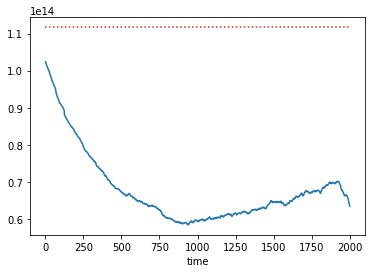

In [82]:
odf.sum(axis=1).plot();
plt.hlines([voli_na], 0, 2000, color='C3', linestyle=':');

RGI01 Failing glaciers: 64
RGI02 Failing glaciers: 960
RGI03 Failing glaciers: 213
RGI04 Failing glaciers: 4
RGI05 Failing glaciers: 1062
RGI06 Failing glaciers: 14
RGI07 Failing glaciers: 881
RGI08 Failing glaciers: 4
RGI09 Failing glaciers: 458
RGI10 Failing glaciers: 136
RGI11 Failing glaciers: 35
RGI12 Failing glaciers: 339
RGI16 Failing glaciers: 311
RGI18 Failing glaciers: 37
RGI19 Failing glaciers: 1974


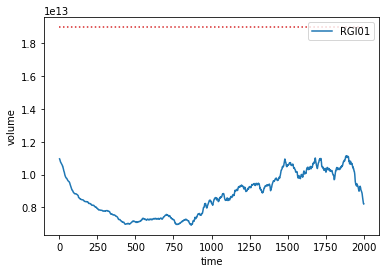

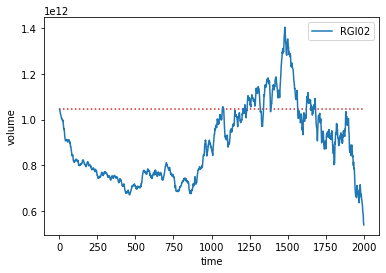

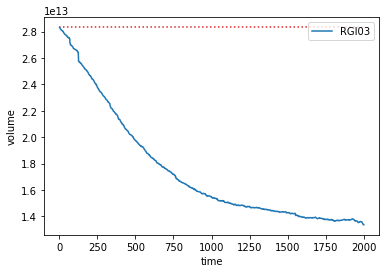

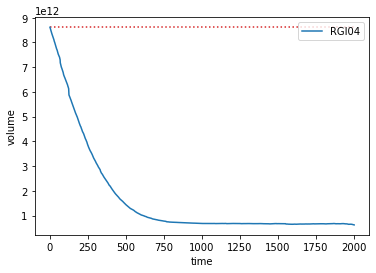

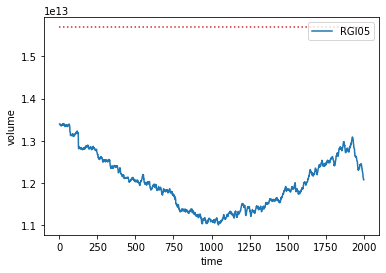

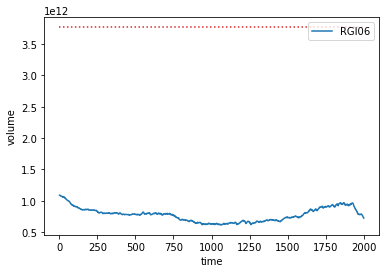

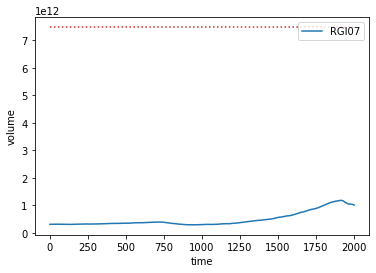

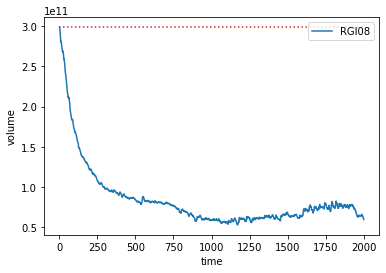

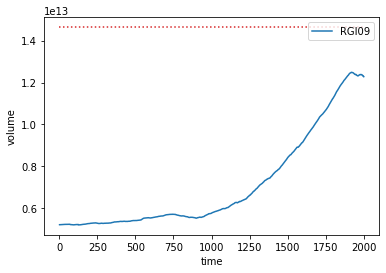

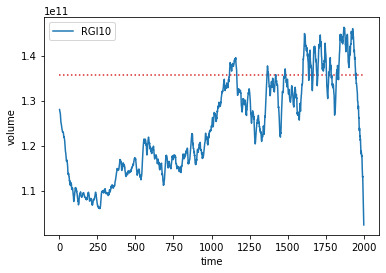

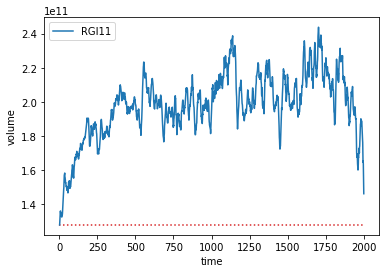

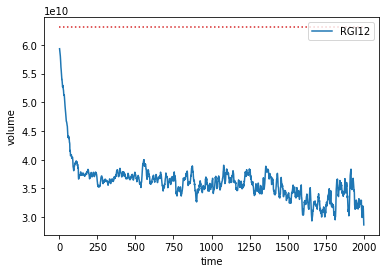

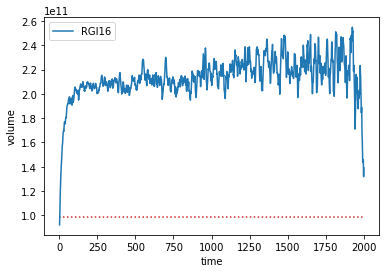

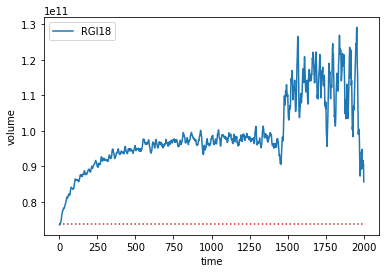

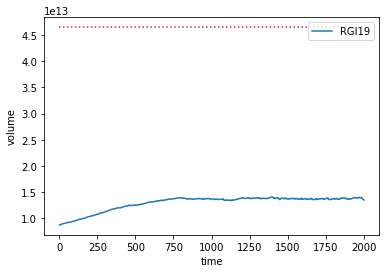

In [84]:
odfm = pd.DataFrame()
for reg in range(1, 20):
    fp = f'output_match_cera/RGI{reg:02d}.nc'
    if not os.path.exists(fp):
        continue
    with xr.open_dataset(fp) as ds:
        print('RGI{:02d} Failing glaciers: {}'.format(reg, int(ds.volume.isel(time=0).isnull().sum())))
        tot_vol = ds.volume.sum(dim='rgi_id')
        
        plt.figure()
        tot_vol.plot(label=f'RGI{reg:02d}');
        plt.hlines([dfir.loc[f'{reg:02d}'].vol_itmix_m3], 0, 2000, color='C3', linestyle=':');
        plt.legend();
        
        odfm[f'RGI{reg:02d}'] = tot_vol.to_series()

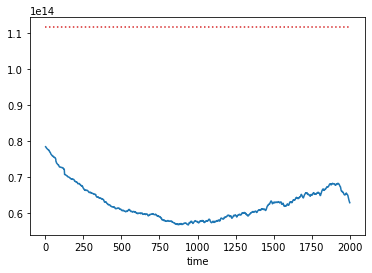

In [86]:
odfm.sum(axis=1).plot();
plt.hlines([voli_na], 0, 2000, color='C3', linestyle=':');